In [101]:
#https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [102]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [103]:
train.shape

(1458644, 11)

In [104]:
test.shape

(625134, 9)

In [105]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [106]:
print ("No need to worry about missing value") if train.count().min()==train.shape[0] else print(" Missing values present")

No need to worry about missing value


In [107]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [108]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
train.loc[:,'pickup_date']=train.pickup_datetime.dt.date
train.store_and_fwd_flag=1*(train.store_and_fwd_flag.values=='Y')

test.pickup_datetime=pd.to_datetime(test.pickup_datetime)
test.loc[:,'pickup_date']=test.pickup_datetime.dt.date
test.store_and_fwd_flag=1*(test.store_and_fwd_flag.values=='Y')

In [109]:
train.check_trip_duration=(train.dropoff_datetime-train.pickup_datetime).map(lambda x:x.total_seconds())
duration_diff=train[np.abs(train.trip_duration.values-train.check_trip_duration.values)>1]
print('Trip duration times are good...') if duration_diff.shape[0]==0 else print('OOps')

Trip duration times are good...


In [110]:
train['trip_duration'].max()//3600

979

In [111]:
train['log_trip_duration']=np.log(train.trip_duration.values+1)

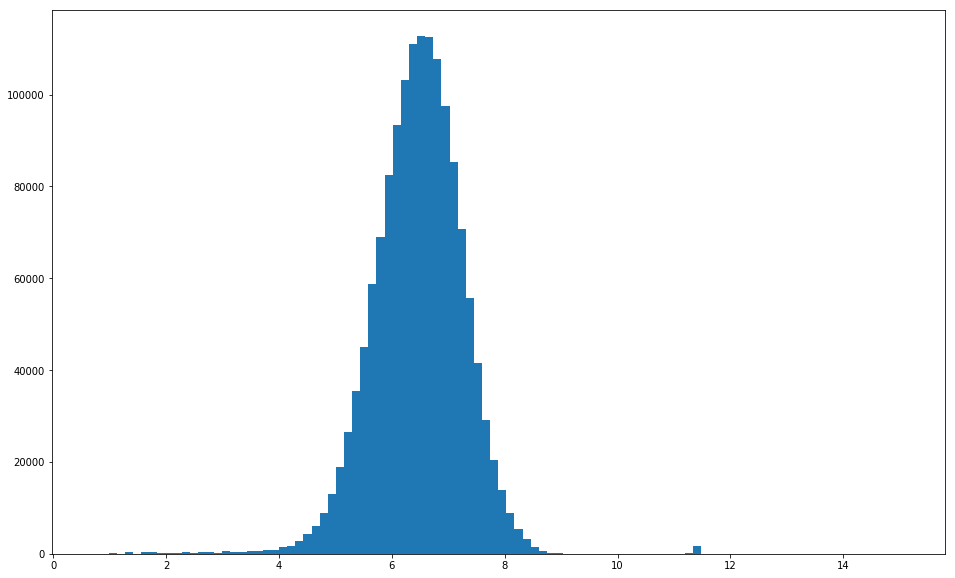

In [112]:
plt.hist(train['log_trip_duration'].values,bins=100)
plt.show()


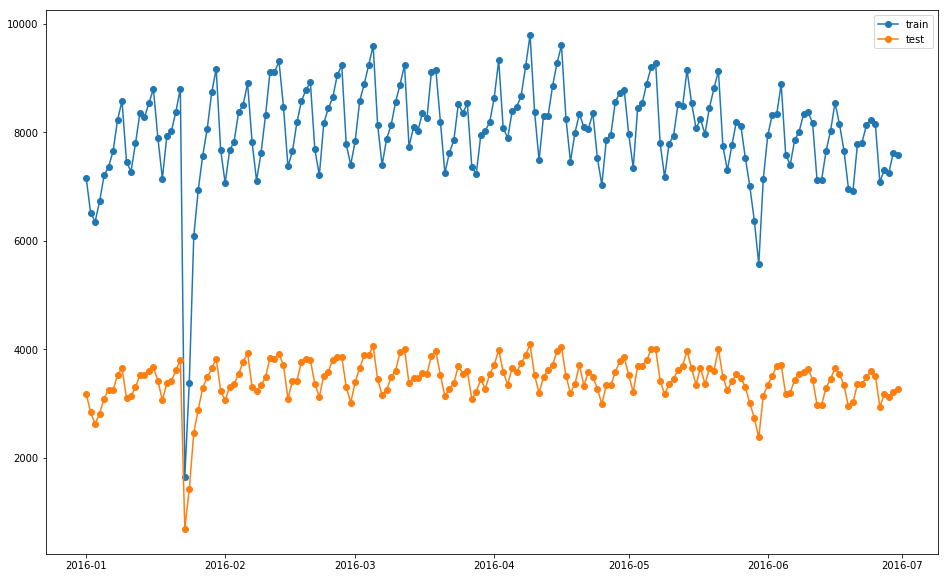

In [113]:
plt.plot(train.groupby('pickup_date').count()['id'],'o-',label='train')
plt.plot(test.groupby('pickup_date').count()['id'],'o-',label='test')
plt.legend(loc=0)
plt.figure(figsize=(5,1))
plt.show()

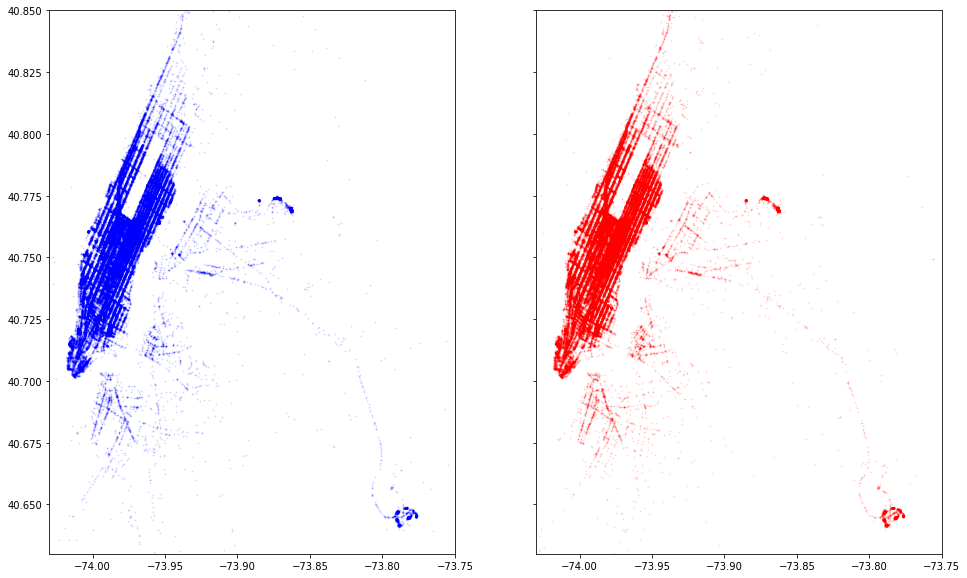

In [114]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig,ax=plt.subplots(ncols=2,sharex=True,sharey=True)
N=100000
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue',label='train')
ax[1].scatter(test['pickup_longitude'].values[:N],test['pickup_latitude'].values[:N],s=1,alpha=.1,color='red',label='test')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [115]:
#Feature extraction
#PCA
coords=np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                  train[['dropoff_latitude','dropoff_longitude']].values,
                 test[['pickup_latitude','pickup_longitude']].values,
                 test[['dropoff_latitude','dropoff_longitude']].values))
pca=PCA().fit(coords)

train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]


test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]

(-0.13426186697746503, 0.1017816834266389)

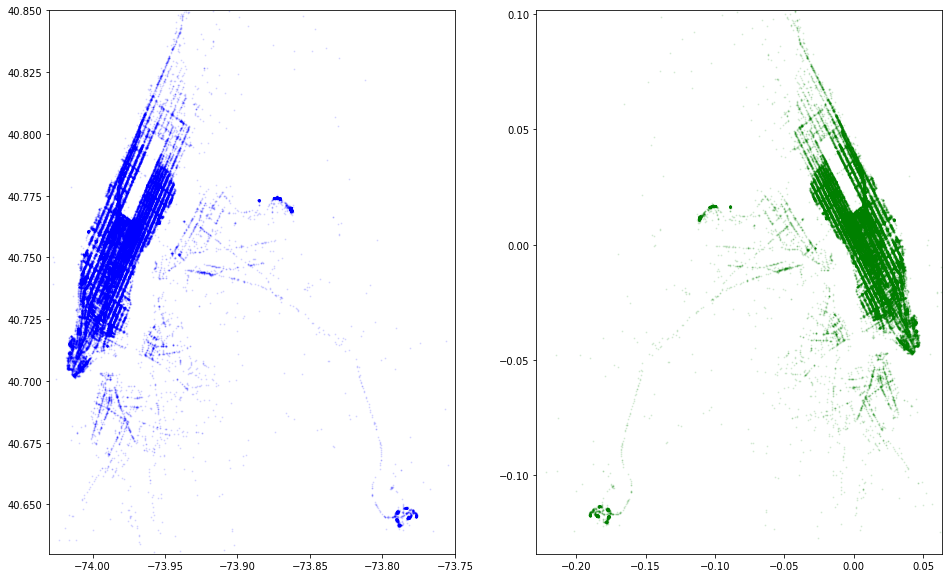

In [116]:
fig,ax=plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue')
ax[1].scatter(train['pickup_pca0'].values[:N],train['pickup_pca1'].values[:N],s=1,alpha=.1,color='green')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders=pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(),pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(),pca_borders[:,1].max())

In [117]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [118]:
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                  train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                                 train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                      train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

In [119]:
test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                  test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                                 test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                      test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

In [120]:
train.loc[:,'center_latitude']=(train['pickup_latitude'].values+train['dropoff_latitude'].values)/2
train.loc[:,'center_longitude']=(train['pickup_longitude'].values+train['dropoff_longitude'].values)/2
test.loc[:,'center_latitude']=(test['pickup_latitude'].values+test['dropoff_latitude'].values)/2
test.loc[:,'center_longitude']=(test['pickup_longitude'].values+test['dropoff_longitude'].values)/2

In [121]:
#Datetime Features

In [122]:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_weekofyear']=train.pickup_datetime.dt.weekofyear
train.loc[:,'pickup_hour']=train.pickup_datetime.dt.hour
train.loc[:,'pickup_minute']=train.pickup_datetime.dt.minute
train.loc[:,'pickup_weekhour']=(train.pickup_datetime.dt.weekday*24)+train.pickup_datetime.dt.hour

In [123]:
test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_weekofyear']=test.pickup_datetime.dt.weekofyear
test.loc[:,'pickup_hour']=test.pickup_datetime.dt.hour
test.loc[:,'pickup_minute']=test.pickup_datetime.dt.minute
test.loc[:,'pickup_weekhour']=(test.pickup_datetime.dt.weekday*24)+test.pickup_datetime.dt.hour

In [124]:
#speed

In [125]:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']

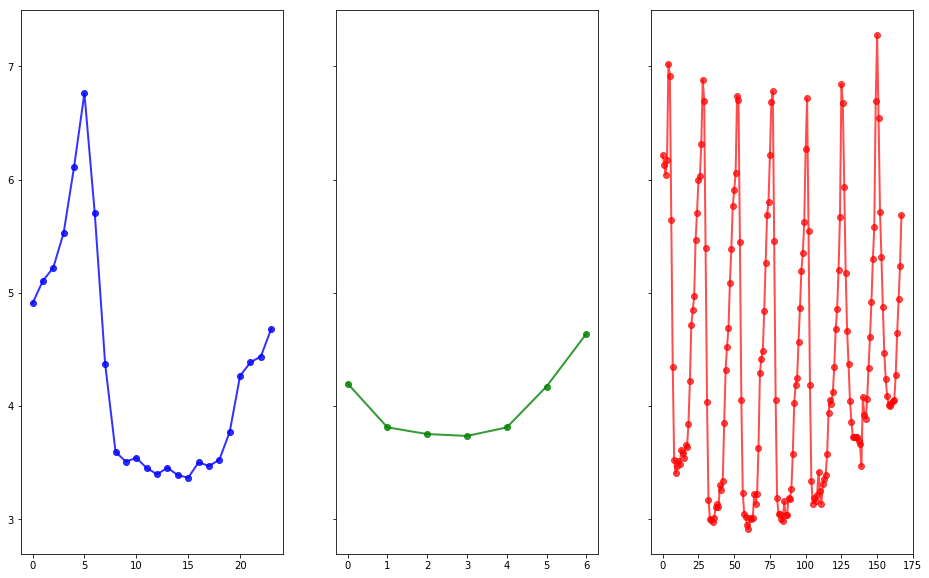

In [126]:
fig,ax=plt.subplots(ncols=3,sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'],'bo-',lw=2,alpha=.8)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'],'go-',lw=2,alpha=.8)
ax[2].plot(train.groupby('pickup_weekhour').mean()['avg_speed_h'],'ro-',lw=2,alpha=.7)

In [127]:
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'].values,3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'].values,3)

gby_cols=['pickup_lat_bin','pickup_long_bin']
coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
coord_status=pd.merge(coord_speed,coord_count,on=gby_cols)
coord_status=coord_status[coord_status['id']>100]

(40.63, 40.85)

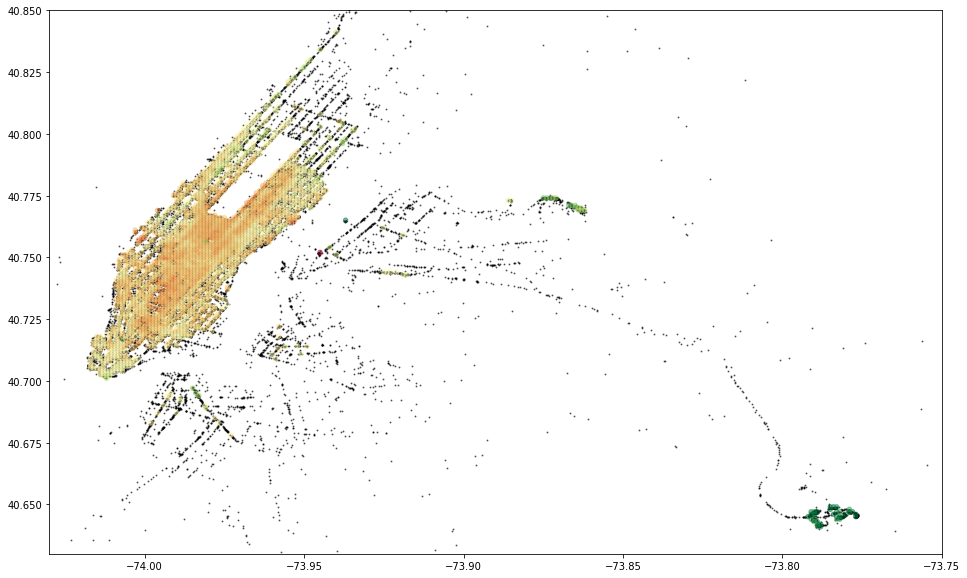

In [128]:
fig,ax=plt.subplots(ncols=1,nrows=1)
ax.scatter(train.pickup_longitude.values[:N],train.pickup_latitude.values[:N],color='black',s=1,alpha=.5)
ax.scatter(coord_status.pickup_long_bin.values,coord_status.pickup_lat_bin.values,
           c=coord_status.avg_speed_h.values,cmap='RdYlGn',s=20,alpha=0.5,vmin=1,vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

In [129]:
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)

In [130]:
#clustering

In [132]:
sample_ind=np.random.permutation(len(coords))[:500000]
kmeans=MiniBatchKMeans(n_clusters=100,batch_size=10000).fit(coords[sample_ind])

In [137]:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])

(40.63, 40.85)

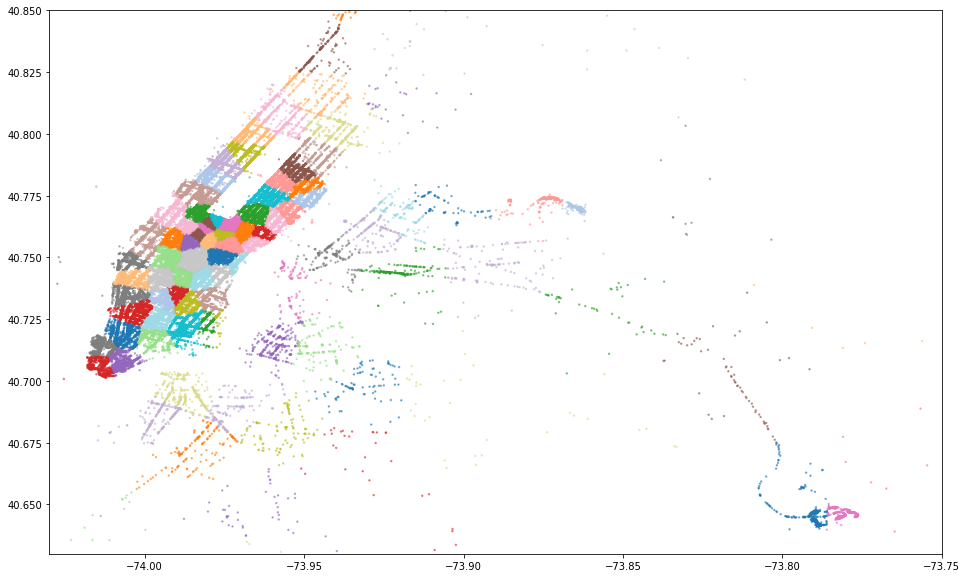

In [150]:
fig,ax=plt.subplots(ncols=1,nrows=1)
ax.scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=2,alpha=.5,
           c=train['pickup_cluster'].values[:N],cmap='tab20')
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

In [151]:
#Temporal and geospatial aggregation

In [164]:
for gby_cols in ['pickup_hour','pickup_date','pickup_weekhour','pickup_cluster','dropoff_cluster']:
    gby=train.groupby(gby_cols).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    print(gby)

             avg_speed_h  avg_speed_m  log_trip_duration
pickup_hour                                             
0               4.907024     6.314784           6.422417
1               5.105336     6.562941           6.373789
2               5.221563     6.708112           6.325211
3               5.528975     7.102727           6.318661
4               6.108814     7.862209           6.328824
5               6.763209     8.762935           6.240214
6               5.700297     7.410019           6.186512
7               4.370429     5.680914           6.349027
8               3.595126     4.662620           6.465236
9               3.508526     4.545711           6.483529
10              3.542108     4.584826           6.486465
11              3.452403     4.470053           6.520644
12              3.397145     4.400084           6.524028
13              3.454446     4.474189           6.537807
14              3.389119     4.391508           6.567917
15              3.366896     4.

                avg_speed_h  avg_speed_m  log_trip_duration
pickup_cluster                                             
0                  4.060804     5.197793           6.542507
1                  3.672907     4.769459           6.462865
2                  7.649163    10.265236           7.566105
3                  4.355041     5.607223           6.011025
4                  4.386409     5.607171           6.345126
5                  4.200265     5.577190           6.338788
6                  4.026475     5.152154           6.311839
7                  5.355131     6.674149           4.321044
8                  3.380251     4.369095           6.432941
9                  5.773385     7.122093           7.451896
10                 4.416354     5.590958           6.386699
11                 6.177107     7.931415           6.270418
12                 3.832232     4.904005           6.413316
13                 3.868245     5.087922           6.340227
14                 4.413101     5.821393

In [166]:
['%s_gby_%s' % (col, 'pickup_date') for col in gby.columns]

['avg_speed_h_gby_pickup_date',
 'avg_speed_m_gby_pickup_date',
 'log_trip_duration_gby_pickup_date']